_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [312]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [313]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [314]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [315]:
# to find the majority class baseline, find the percentage of times
# a shot was made or missed. In this case, the baseline is 53% of the
# time the shot is not made.
df['shot_made_flag'].value_counts(normalize=True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [316]:
from sklearn.model_selection import train_test_split
df.dtypes

game_id                      int64
game_event_id                int64
player_name                 object
period                       int64
minutes_remaining            int64
seconds_remaining            int64
action_type                 object
shot_type                   object
shot_zone_basic             object
shot_zone_area              object
shot_zone_range             object
shot_distance                int64
loc_x                        int64
loc_y                        int64
shot_made_flag               int64
game_date                   object
htm                         object
vtm                         object
season_type                 object
scoremargin_before_shot    float64
dtype: object

In [317]:
# change the game_date type from object to datetime:
df['game_date'] = pd.to_datetime(df['game_date'], infer_datetime_format=True)
df['game_date'].dt.year.value_counts()


2016    1912
2015    1871
2013    1660
2017    1609
2014    1458
2018    1271
2010    1192
2019    1183
2012     759
2011     729
2009     314
Name: game_date, dtype: int64

In [318]:
# test data is June-Oct 2018-2019 needs to have 1709 observations
# df = df.set_index(df['game_date'])
# df = df.sort_index()
test = df[(df['game_date'] >= '2018-06-30') & (df['game_date'] <= '2019-10-01')]
test.shape

(1709, 20)

In [319]:
train = df[(df['game_date'] <= '2018-09-30')]
train.shape

(12249, 20)

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [320]:
train.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [321]:
# will engineer feature of hometown advantage:
train = train.copy()
test = test.copy()
#(to get rid of slice warning)
def hometown_advantage(team):
    if team == 'GSW':
        return 1
    else:
        return 0
train['htm_advantage'] = train['htm'].apply(hometown_advantage)
test['htm_advantage'] = test['htm'].apply(hometown_advantage)
print(train['htm_advantage'].value_counts())
print(train['htm'].value_counts()[:5])
# numbers match

0    6197
1    6052
Name: htm_advantage, dtype: int64
GSW    6052
HOU     352
LAC     332
MEM     331
OKC     326
Name: htm, dtype: int64


# STRETCH ENGINEERED 3 ADDITIONAL FEATURES

In [322]:

# seconds left in period: 
'''Seconds remaining in the period: Combine minutes remaining with 
    seconds remaining, to get the total number of seconds remaining 
    in the period.'''

train['sec_so_far'] = train['minutes_remaining'] * 60
train['sec_remaining_period'] = train['sec_so_far'] + train['seconds_remaining']
test['sec_so_far'] = test['minutes_remaining'] * 60
test['sec_remaining_period'] = test['sec_so_far'] + test['seconds_remaining']


train.head()


,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,htm_advantage,sec_so_far,sec_remaining_period
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1,660,685
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,1,540,571
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,360,362
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,540,589
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,1,120,139


In [323]:
# seconds remaining in game
'''Seconds remaining in the game: Combine period, and seconds remaining 
in the period, to get the total number of seconds remaining in the game. 
A basketball game has 4 periods, each 12 minutes long.'''
train['period_in_sec'] = (train['period'] * 12 * 60)
total_sec_game = 4 * 12 * 60
train['seconds_remaining_game'] = (total_sec_game-(train['period_in_sec'] - 
                              train['sec_remaining_period']))
test['period_in_sec'] = (test['period'] * 12 * 60)
test['seconds_remaining_game'] = (total_sec_game-(test['period_in_sec'] - 
                              test['sec_remaining_period']))
train.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,game_date,htm,vtm,season_type,scoremargin_before_shot,htm_advantage,sec_so_far,sec_remaining_period,period_in_sec,seconds_remaining_game
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,2009-10-28,GSW,HOU,Regular Season,2.0,1,660,685,720,2845
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,2009-10-28,GSW,HOU,Regular Season,0.0,1,540,571,720,2731
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,2009-10-28,GSW,HOU,Regular Season,-4.0,1,360,362,720,2522
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,2009-10-28,GSW,HOU,Regular Season,-4.0,1,540,589,1440,2029
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,2009-10-28,GSW,HOU,Regular Season,0.0,1,120,139,1440,1579


In [328]:
# periods left in game
total_periods = 4
train['periods_left'] = total_periods - train['period']
test['periods_left'] = total_periods - test['period']

In [329]:
train.columns.tolist()

['game_id',
 'game_event_id',
 'player_name',
 'period',
 'minutes_remaining',
 'seconds_remaining',
 'action_type',
 'shot_type',
 'shot_zone_basic',
 'shot_zone_area',
 'shot_zone_range',
 'shot_distance',
 'loc_x',
 'loc_y',
 'shot_made_flag',
 'game_date',
 'htm',
 'vtm',
 'season_type',
 'scoremargin_before_shot',
 'htm_advantage',
 'sec_so_far',
 'sec_remaining_period',
 'period_in_sec',
 'seconds_remaining_game',
 'periods_left']

In [256]:
columns =['game_id','game_event_id', 'player_name',
          'period','minutes_remaining','seconds_remaining','action_type',
          'shot_type','shot_zone_basic','shot_zone_area','shot_zone_range',
          'shot_distance','loc_x','loc_y','game_date','htm',
          'vtm','season_type','scoremargin_before_shot','htm_advantage','sec_so_far',
          'sec_remaining_period','period_in_sec','seconds_remaining_game', 'shot_made_flag']
train = train[columns]
train.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,htm,vtm,season_type,scoremargin_before_shot,htm_advantage,sec_so_far,sec_remaining_period,period_in_sec,seconds_remaining_game,shot_made_flag
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,GSW,HOU,Regular Season,2.0,1,660,685,720,2845,0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,GSW,HOU,Regular Season,0.0,1,540,571,720,2731,1
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,GSW,HOU,Regular Season,-4.0,1,360,362,720,2522,0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,GSW,HOU,Regular Season,-4.0,1,540,589,1440,2029,0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,GSW,HOU,Regular Season,0.0,1,120,139,1440,1579,0


In [330]:
train.shape

(12249, 26)

# STRETCH 2+ VISUALIZATIONS FOR NUMERICAL AND CATEGORICAL FEATURES

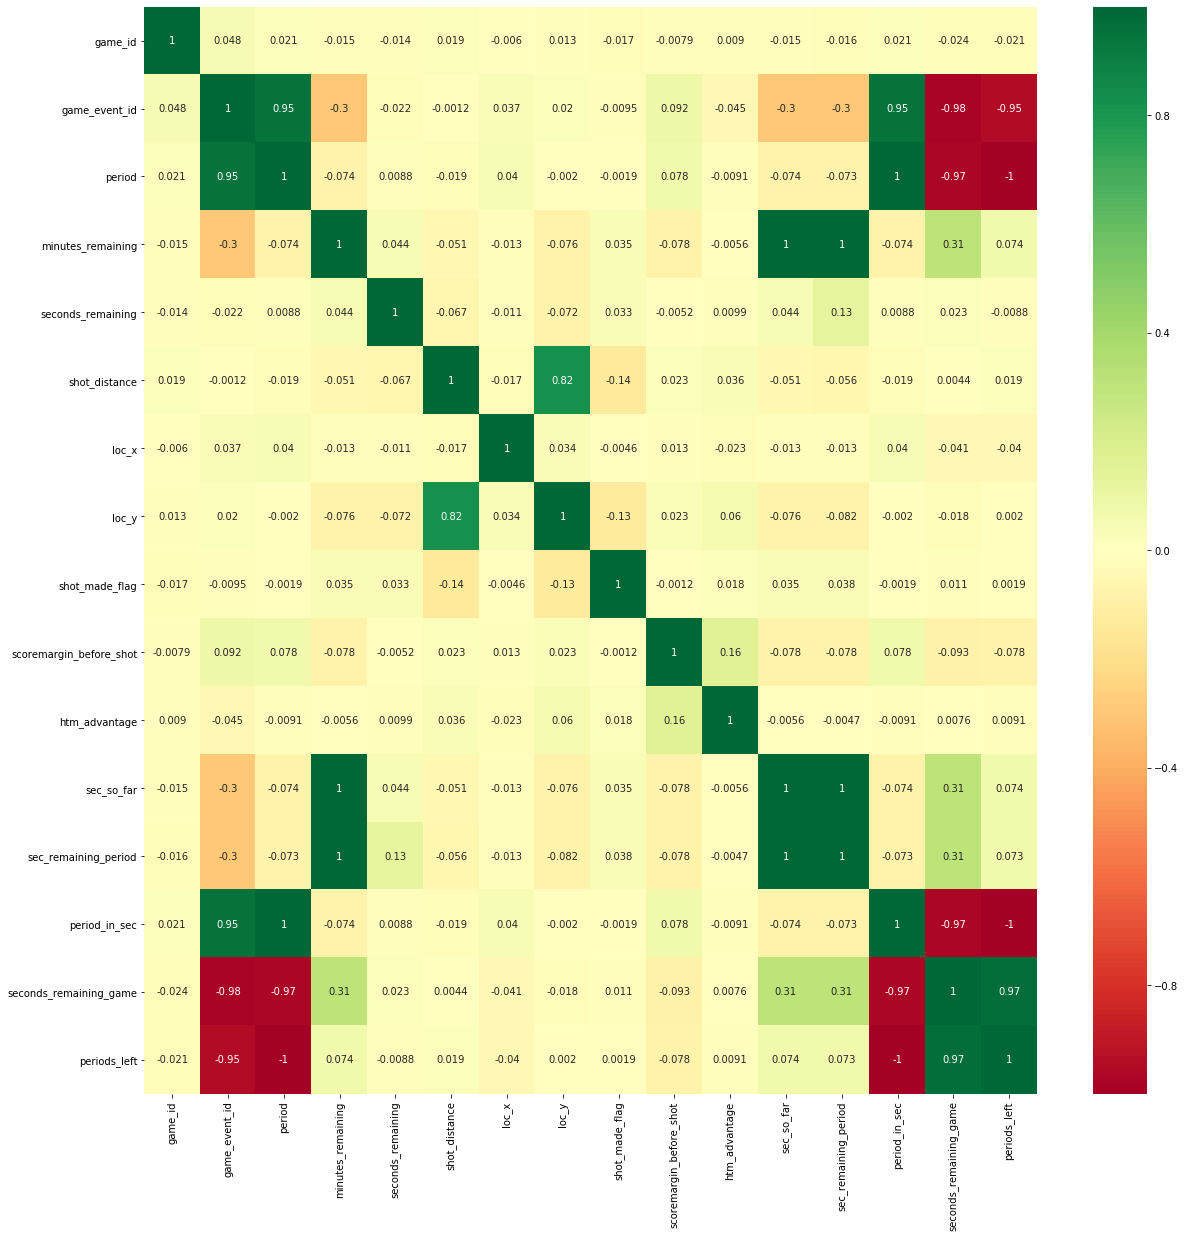

In [327]:
# going to try to clean some stuff up before fit model:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

X = train.iloc[:,0:25]  #independent columns
y = train.iloc[:,-1]    #target column i.e shot flag
#get correlations of each features in dataset
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [331]:
# going to drop game_event ID, highly correlated coincidentally with
# other columns. Also will drop loc x and loc y because loc y is correlated
# with shot distance:
# also drop extra time columns
train = train.drop(columns=['game_event_id', 'loc_x', 'loc_y', 'period_in_sec',
                           'sec_so_far', 'sec_remaining_period', 'period','periods_left'])

In [332]:
# also need to remove from test:
test = test.drop(columns=['game_event_id', 'loc_x', 'loc_y','period_in_sec',
                           'sec_so_far', 'sec_remaining_period', 'period', 'periods_left'])

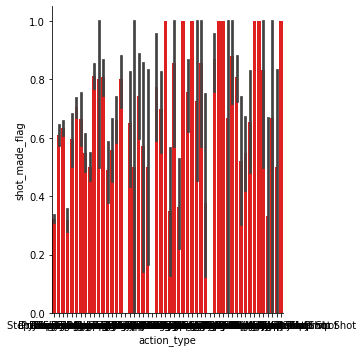

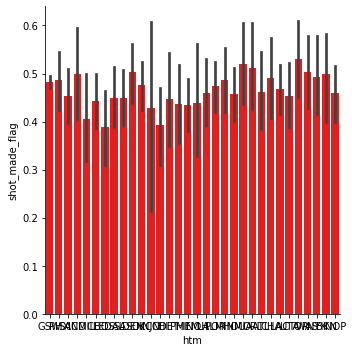

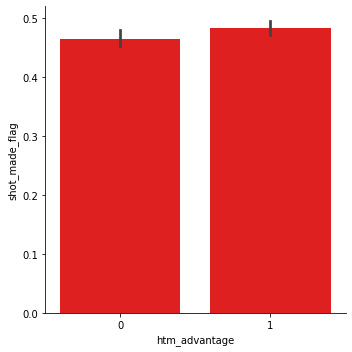

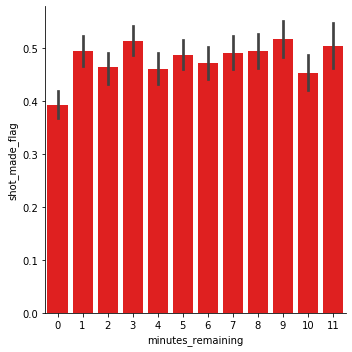

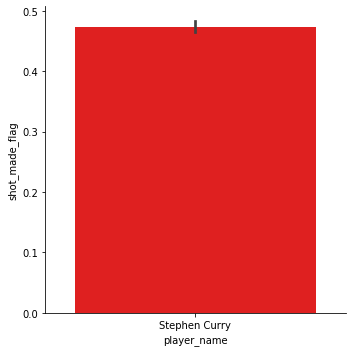

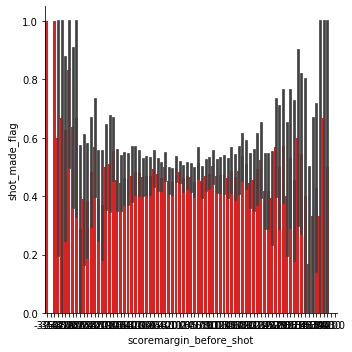

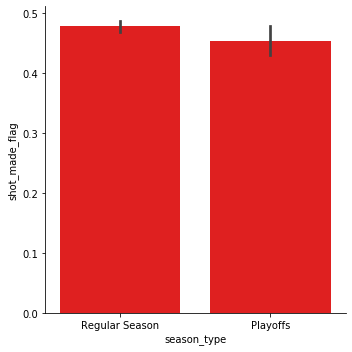

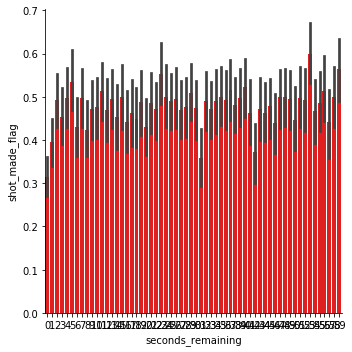

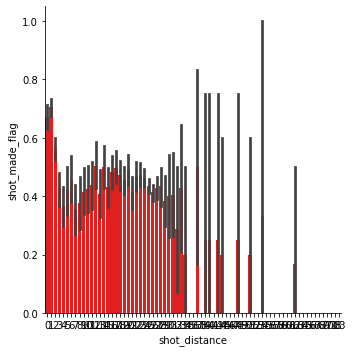

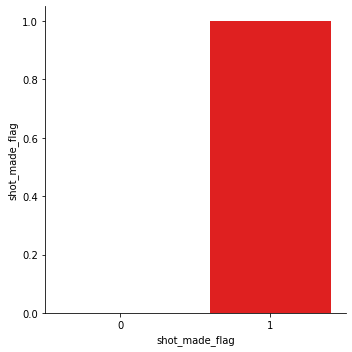

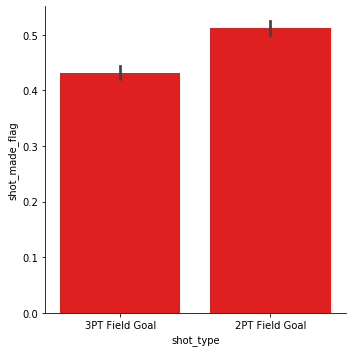

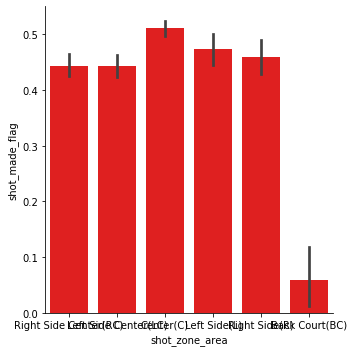

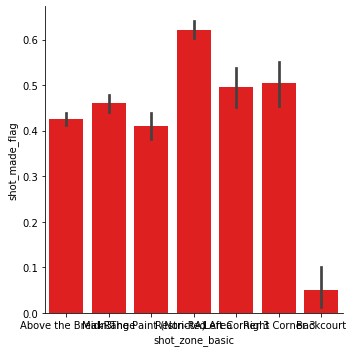

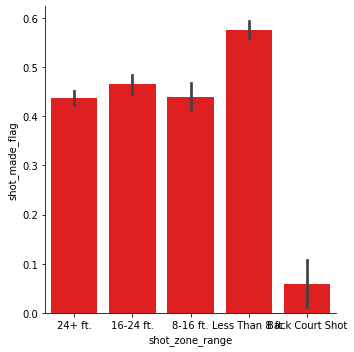

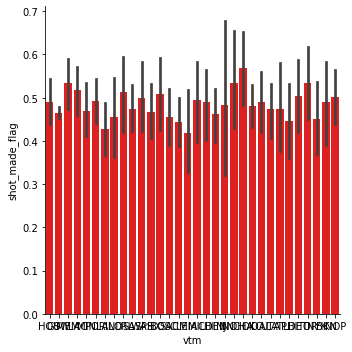

In [261]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for col in sorted(train.columns):
    if train[col].nunique() < 100:
        try:
            sns.catplot(x=col, y='shot_made_flag', data=train, kind='bar', color='red')
            plt.show()
        except:
            pass

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [262]:
#Train/validate/test split: random 80/20% train/validate split.
train, val = train_test_split(train, train_size=.8, test_size=.2, 
                              random_state=42)
train.shape, val.shape, test.shape

((9799, 18), (2450, 18), (1709, 18))

In [263]:
train.columns.tolist()

['game_id',
 'player_name',
 'minutes_remaining',
 'seconds_remaining',
 'action_type',
 'shot_type',
 'shot_zone_basic',
 'shot_zone_area',
 'shot_zone_range',
 'shot_distance',
 'game_date',
 'htm',
 'vtm',
 'season_type',
 'scoremargin_before_shot',
 'htm_advantage',
 'seconds_remaining_game',
 'shot_made_flag']

In [285]:
# set X feature matrices and y target vectors:
target = 'shot_made_flag'
features = ['game_id',
 'seconds_remaining',
 'action_type',
 'shot_type',
 'shot_zone_basic',
 'shot_zone_area',
 'shot_zone_range',
 'shot_distance',
 'htm',
 'vtm',
 'season_type',
 'scoremargin_before_shot',
 'htm_advantage',
 'seconds_remaining_game',
           'minutes_remaining']


X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [286]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
my_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=100)
)

my_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Pullup Jump shot                       2
Step Back Jump shot                    3
Layup S...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
               

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [273]:
print('Validation Accuracy', my_pipeline.score(X_val, y_val))

Validation Accuracy 0.6453061224489796


In [277]:
# with dropping player name:
print('Validation Accuracy', my_pipeline.score(X_val, y_val))

Validation Accuracy 0.6477551020408163


In [280]:
# with dropping minutes remaining 
print('Validation Accuracy', my_pipeline.score(X_val, y_val))
# will add it back in.

Validation Accuracy 0.6473469387755102


In [284]:
# drop game ID and add back in minutes remaining:
print('Validation Accuracy', my_pipeline.score(X_val, y_val))


Validation Accuracy 0.636734693877551


In [287]:
# add back in game ID
print('Validation Accuracy', my_pipeline.score(X_val, y_val))

Validation Accuracy 0.6444897959183673


# STRETCH FEATURE IMPORTANCES

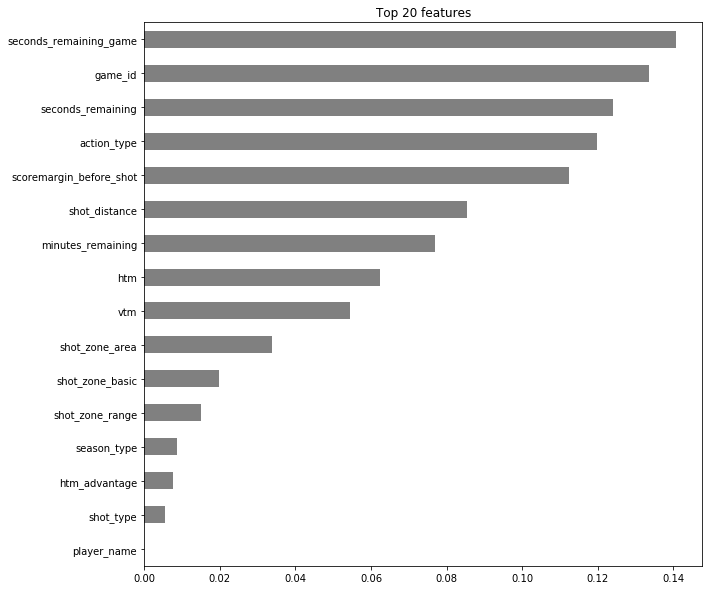

In [274]:
# Get feature importances
rf1 = my_pipeline.named_steps['randomforestclassifier']
encoder = my_pipeline.named_steps['ordinalencoder']
encoded1 = encoder.transform(X_train)
importances1 = pd.Series(rf1.feature_importances_, encoded1.columns)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances1.sort_values()[-n:].plot.barh(color='grey');

# STRETCH RANDOMIZED CV FOR OPTIMIZED PARAMETERS

In [291]:
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(random_state=42)
)

param_distributions = {
    'randomforestclassifier__n_estimators': randint(50, 500, 10), 
    'randomforestclassifier__max_depth': [5, 10, 15, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=3, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    7.4s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    7.8s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   10.9s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   11.0s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   12.4s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.7s finished


In [294]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.6854023786487123, 'randomforestclassifier__n_estimators': 168}
Cross-validation accuracy 0.6552709460148994


In [296]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
my_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=168, max_depth=10, 
                           max_features=0.6854023786487123, random_state=42, 
                           n_jobs=-1)
)

my_pipeline.fit(X_train, y_train)
print('Validation Accuracy', my_pipeline.score(X_val, y_val))

Validation Accuracy 0.6689795918367347


## 7. Get your model's test accuracy

> (One time, at the end.)

In [333]:
print('Test Accuracy', my_pipeline.score(X_test, y_test))

Test Accuracy 0.6372147454651843


## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [43]:
#correct_predictions_postivie/total_predictions
total_predictions = 85 + 58 + 8 + 36
correct_predictions = 85 + 36

print('accuracy:', correct_predictions/total_predictions)

accuracy: 0.6470588235294118


### Calculate precision

In [45]:
# correct_predictions_positive/total_predictions_positive
correct_predictions_positive = 36
total_predictions_positive = 58 + 36
print('precision positive', 
      correct_predictions_positive/total_predictions_positive)
# correct_predictions_negative/total_predictions_negative
correct_predictions_negative = 85
total_predictions_negative = 85 + 8
print('precision negative',
      correct_predictions_negative/total_predictions_negative)

precision positive 0.3829787234042553
precision negative 0.9139784946236559


### Calculate recall

In [47]:
# correct_predictions_positive/actual_positive
actual_positive = 8 + 36
print('recall positive', correct_predictions_positive/actual_positive)
# correct_predictions_negative/actual_negative
actual_negative = 85 + 58
print('recall negative', correct_predictions_negative/actual_negative)

recall positive 0.8181818181818182
recall negative 0.5944055944055944
